In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, tf_data, tf_classification, get_np_images

print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Defining parameters

h = 256
w = 256
channels = 3
batch_size = 8
buffer_size = 200
num_epochs = 20
lr = 1e-4
seed = 42
np.random.seed = seed

In [4]:
train_path_hr='Datasets/HYPERTENSION/HR_aug/train'
train_path_nhr='Datasets/HYPERTENSION/HR_aug/train_nonhr'
test_path_hr='Datasets/HYPERTENSION/HR_aug/val'
test_path_nhr='Datasets/HYPERTENSION/HR_aug/val_nonhr'

X_train_hr, X_train_nhr = load_path(train_path_hr, train_path_nhr)
X_test_hr, X_test_nhr = load_path(test_path_hr, test_path_nhr)

Y_train_hr = np.ones(len(X_train_hr))
Y_train_nhr = np.zeros(len(X_train_nhr))
Y_test_hr = np.ones(len(X_test_hr))
Y_test_nhr = np.zeros(len(X_test_nhr))

In [5]:
X_train = X_train_hr + X_train_nhr
Y_train = np.concatenate((Y_train_hr, Y_train_nhr), axis = None)
Y_train = Y_train[:, None]
X_test = X_test_hr + X_test_nhr
Y_test = np.concatenate((Y_test_hr, Y_test_nhr), axis = None)
Y_test = Y_test[:, None]

In [6]:
Train = tf_classification(X_train, Y_train, buffer_size, batch_size, num_epochs)
Test = tf_classification(X_test, Y_test, buffer_size, batch_size, num_epochs)

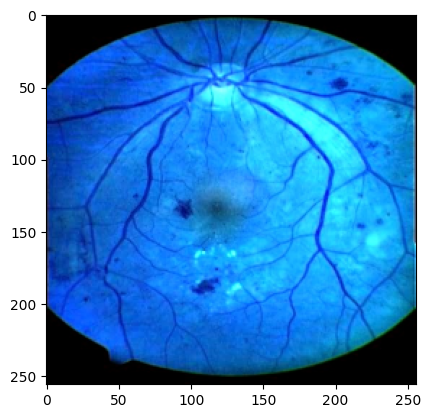

tf.Tensor([1.], shape=(1,), dtype=float32)


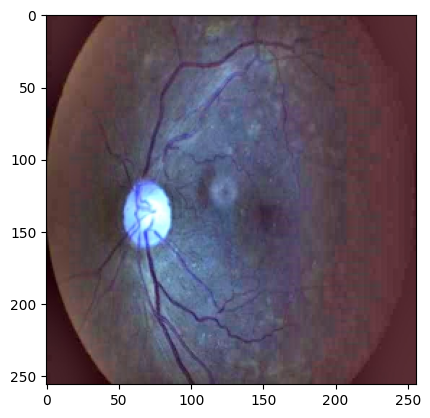

tf.Tensor([1.], shape=(1,), dtype=float32)


In [7]:
for x, y in Train:
    plt.imshow(x[1]);
    plt.show();
    print(y[1])
    break
    
for x, y in Test:
    plt.imshow(x[1]);
    plt.show();
    print(y[1])
    break

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [9]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.applications.xception import Xception
from tensorflow.keras.regularizers import l2

In [10]:
input_shape = (h, w, 3)
inputs = Input(shape = (h, w, 3))

base_model = Xception(weights = 'imagenet', include_top = False, input_shape = input_shape)
for layer in base_model.layers:
    layer.trainable = False

x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(56, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(28, activation = 'relu')(x)

predictions = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs = inputs, outputs = predictions)

In [11]:
train_steps = len(X_train)//batch_size
test_steps = len(X_test)//batch_size
if len(X_train) % batch_size != 0:
    train_steps += 1
if len(X_test) % batch_size != 0:
    test_steps += 1

model.compile(optimizer = Adam(lr), loss = 'binary_crossentropy', metrics = ['accuracy', Recall(), Precision()])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 56)                7224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 56)               

In [12]:
model_path = os.path.join('HR.h5')
csv_path = os.path.join('HR.csv')

callbacks=[
    ModelCheckpoint(model_path, verbose = 1, save_best_only = True),
    tf.keras.callbacks.EarlyStopping(patience = 50, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs'),
    CSVLogger(csv_path),
]

results=model.fit(
    Train,
    validation_data = Test, 
    batch_size = batch_size, 
    steps_per_epoch = train_steps,
    validation_steps = test_steps,
    epochs = 20, 
    callbacks=callbacks)

Epoch 1/20
  1/202 [..............................] - ETA: 0s - loss: 0.4732 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000WARNING:tensorflow:From C:\Users\User\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
202/202 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.8854 - recall: 0.9438 - precision: 0.7648
Epoch 00001: val_loss improved from inf to 0.77319, saving model to HR.h5
202/202 [==============================] - 66s 325ms/step - loss: 0.3728 - accuracy: 0.8854 - recall: 0.9438 - precision: 0.7648 - val_loss: 0.7732 - val_accuracy: 0.7043 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/20
201/202 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.8924 - recall: 0.8408 - precision: 0.8361
Epoch 00002: val_loss

Epoch 19/20
201/202 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9975 - recall: 0.9981 - precision: 0.9944
Epoch 00019: val_loss did not improve from 0.04808
202/202 [==============================] - 56s 279ms/step - loss: 0.0088 - accuracy: 0.9975 - recall: 0.9981 - precision: 0.9944 - val_loss: 0.0634 - val_accuracy: 0.9812 - val_recall: 0.9657 - val_precision: 0.9704
Epoch 20/20
201/202 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9994 - recall: 0.9981 - precision: 1.0000
Epoch 00020: val_loss did not improve from 0.04808
202/202 [==============================] - 56s 277ms/step - loss: 0.0050 - accuracy: 0.9994 - recall: 0.9981 - precision: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9812 - val_recall: 0.9657 - val_precision: 0.9704


In [15]:
# from load_data import read_image

# for i in range(len(X_test)):
#     x = read_image(X_test[i])
#     y_pred = model.predict(np.expand_dims(x, axis = 0))
#     print((y_pred>=0.5)==Y_test[i])
print('Train result: ')
results = model.evaluate(Train, batch_size = 128)
print('Test result: ')
results = model.evaluate(Test, batch_size = 128)

Train result: 
4040/4040 [==============================] - 825s 204ms/step - loss: 0.0037 - accuracy: 0.9988 - recall: 0.9963 - precision: 1.0000
Test result: 
1740/1740 [==============================] - 389s 223ms/step - loss: 0.0534 - accuracy: 0.9812 - recall: 0.9657 - precision: 0.9704


In [16]:
model.save('HR_final.h5')

In [1]:
from tensorboard import notebook
notebook.list()
notebook.display(port=6006, height=1000)

Known TensorBoard instances:
  - port 6006: logdir logs (started 13:42:18 ago; pid 9844)
Selecting TensorBoard with logdir logs (started 13:42:18 ago; port 6006, pid 9844).
